### Load Library

In [3]:
import os
import re
import logging
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment


### Load Dataset

In [2]:
# load data
df = pd.read_csv('data/songs_wav.csv', sep=",")

df.head()

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,Bungong Jeumpa | Lirik dan Terjemahan | Lagu D...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,243,https://www.youtube.com/watch?v=lAVi2OE2bRY,datasets/songs/bungong_jeumpa_lirik_dan_terjem...,datasets/wav_songs/bungong_jeumpa_lirik_dan_te...
1,VIDEO LIRIK- BUNGONG JEUMPA,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,264,https://www.youtube.com/watch?v=tgc0dBKcqhE,datasets/songs/video_lirik_bungong_jeumpa.mp3,datasets/wav_songs/video_lirik_bungong_jeumpa.wav
2,Bungong Jeumpa - Putri Ariani Cover (Lagu Daer...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,160,https://www.youtube.com/watch?v=RjI7W_XmzLM,datasets/songs/bungong_jeumpa_putri_ariani_cov...,datasets/wav_songs/bungong_jeumpa_putri_ariani...
3,Bungong Jeumpa,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,259,https://www.youtube.com/watch?v=_M1ZNoY99nk,datasets/songs/bungong_jeumpa.mp3,datasets/wav_songs/bungong_jeumpa.wav
4,Bungong Jeumpa - Tania,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,218,https://www.youtube.com/watch?v=ZfZxIR9vRmk,datasets/songs/bungong_jeumpa_tania.mp3,datasets/wav_songs/bungong_jeumpa_tania.wav


### Data Preprocessing

In [6]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        nama_lagu = row['nama_lagu']
        
        os.makedirs(f"{output_base_folder}/{normalized_yt_title(nama_lagu)}", exist_ok=True)
        
        audio = AudioSegment.from_wav(wav_path)
        total_duration = len(audio) / 1000
        segment_duration = 30
        num_segments = int(total_duration // segment_duration)
        
        for i in range(num_segments):
            start_time = i * segment_duration * 1000 
            end_time = (i + 1) * segment_duration * 1000
            segment = audio[start_time:end_time]
            
            segment_file = f"{output_base_folder}/{normalized_yt_title(nama_lagu)}/segment_{index}_{i}.wav"
            segment.export(segment_file, format="wav")
            
            split_result.append({
                'title': nama_lagu,
                '30s_path': segment_file
            })
        print(f"Saved {num_segments} segments for {nama_lagu} at: {output_base_folder}/{normalized_yt_title(nama_lagu)}")
        

In [7]:
split_songs_to_segments(df)

Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 5 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 7 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 6 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 13 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 9 segments for Mecepat – Cepetan at: datasets/30s_segments/mecepat_cepetan
Saved 4 segments for Mecepat – Cepetan at: datasets/30s_segments/mecepat_cepetan
Saved 9 segments for Mecepat – Cepetan at: datasets/30s_segments/me

In [9]:
# save split result to csv
split_result_df = pd.DataFrame(split_result)
split_result_df.to_csv('data/30s_segments.csv', index=False)

### Data Augmentation

In [6]:
df_res = pd.read_csv('data/30s_segments.csv', sep=",")
df_res.head()

,title,30s_path
0,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
1,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
2,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
3,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
4,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...


In [59]:
import random

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=1.0):
    return librosa.effects.time_stretch(data, rate)

def pitch_shift(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr, n_steps)

def pad_or_truncate(data, length):
    if len(data) > length:
        return data[:length]
    elif len(data) < length:
        return np.pad(data, (0, length - len(data)), 'constant')
    return data

def augment_audio(data, sr):
    augmentations = [
        lambda x: stretch(x, rate=random.uniform(0.8, 1.2)),
        lambda x: pitch_shift(x, sr, n_steps=random.randint(-3, 3))
    ]
    
    aug = random.choice(augmentations)
    try:
        augmented_data = aug(data)
        augmented_data = pad_or_truncate(augmented_data, len(data))
    except Exception as e:
        logging.error(f"Error encountered during augmentation: {e}")
        return data  # Return the original data if augmentation fails
    
    return augmented_data

### Feature Extraction

In [56]:
# extract the feature using mfcc
def mfcc_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path)
        audio = augment_audio(audio, sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mfccs_processed

def chroma_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path) 
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return chroma_processed

def mel_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path) 
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(mel.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mel_processed

def combined_features(file_path):
    mfcc = mfcc_features(file_path)
    chroma = chroma_features(file_path)
    # mel = mel_features(file_path)
    
    return np.concatenate((mfcc, chroma))

In [57]:
mfcc_features(df_res['30s_path'][1])

ERROR:root:Error encountered during augmentation: pitch_shift() takes 1 positional argument but 3 were given


array([-94.453255  ,  85.354416  ,  19.829857  ,  29.550518  ,
         3.3427606 ,   8.767343  ,  -1.0440549 ,  -1.7061552 ,
        -2.474878  ,  -4.923844  ,  -5.4945765 ,  -3.9698446 ,
        -7.160829  ,  -2.9844337 , -11.295804  ,   4.6269417 ,
        -8.308516  ,   4.369019  ,  -2.1354835 ,   6.3316226 ,
         4.1712747 ,   8.597622  ,   0.25409794,   0.24103652,
        -2.9344056 ,   0.15135483,  -1.2232895 ,  -6.681141  ,
        -9.368619  ,  -3.8600621 ,   1.9096661 ,   6.618542  ,
        -4.0391874 ,  -6.199547  ,  -7.785176  ,  -2.429788  ,
        -5.588207  ,  -0.8520634 ,   0.82610166,   4.957952  ],
      dtype=float32)

In [58]:
# df_res['features'] = df_res['30s_path'].apply(combined_features)
df_res['mfcc_features'] = df_res['30s_path'].apply(mfcc_features)
# df_res['mfcc_12_features'] = df_res['30s_path'].apply(combined_features)

ERROR:root:Error encountered during augmentation: time_stretch() takes 1 positional argument but 2 were given
ERROR:root:Error encountered during augmentation: time_stretch() takes 1 positional argument but 2 were given
ERROR:root:Error encountered during augmentation: time_stretch() takes 1 positional argument but 2 were given
ERROR:root:Error encountered during augmentation: time_stretch() takes 1 positional argument but 2 were given
ERROR:root:Error encountered during augmentation: pitch_shift() takes 1 positional argument but 3 were given
ERROR:root:Error encountered during augmentation: pitch_shift() takes 1 positional argument but 3 were given
ERROR:root:Error encountered during augmentation: time_stretch() takes 1 positional argument but 2 were given
ERROR:root:Error encountered during augmentation: time_stretch() takes 1 positional argument but 2 were given
ERROR:root:Error encountered during augmentation: time_stretch() takes 1 positional argument but 2 were given
ERROR:root:E

In [60]:
df_res.to_csv('data/30s_segments_features.csv', index=False)
df_res.head()

,title,30s_path,mfcc_features
0,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-145.76633, 73.25051, 17.235668, 27.067945, 7..."
1,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-94.453255, 85.354416, 19.829857, 29.550518, ..."
2,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-101.57153, 81.89458, 18.537878, 31.281668, 3..."
3,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-97.65199, 88.235756, 17.676033, 23.640873, 3..."
4,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-97.441696, 77.95034, 13.51779, 30.438295, 3...."


In [61]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

label_encoder = LabelEncoder()

X = np.array(df_res['mfcc_features'].tolist())
y = label_encoder.fit_transform(df_res['title'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
columns = ['class_name', 'class_code']
class_names = pd.DataFrame(columns=columns)
class_names['class_name'] = label_encoder.classes_
class_names['class_code'] = label_encoder.transform(label_encoder.classes_)

class_names.to_csv('model/class_names.csv', index=False)

In [63]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (6299, 40)
X_test shape: (1575, 40)


In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define the model
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

2024-12-05 22:16:24.579433: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 22:16:24.800425: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 22:16:24.992312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733411785.152442    2806 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733411785.196210    2806 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 22:16:25.616773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [65]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 103)            │        13,287 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,975 (2.87 MB)

 Trainable params: 748,135 (2.85 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0318 - loss: 4.9587 - val_accuracy: 0.0610 - val_loss: 4.9174
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1335 - loss: 4.0056 - val_accuracy: 0.2883 - val_loss: 3.3172
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2281 - loss: 3.4947 - val_accuracy: 0.3683 - val_loss: 2.8601
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3194 - loss: 3.0009 - val_accuracy: 0.4546 - val_loss: 2.5140
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3720 - loss: 2.7379 - val_accuracy: 0.5022 - val_loss: 2.2425
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4533 - loss: 2.3469 - val_accuracy: 0.5505 - val_loss: 2.0253
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5021 - loss: 2.1301 - val_accuracy: 0.6000 - val_loss: 1.7375
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5345 - loss: 1.9318 - val_accuracy: 0.

In [67]:
train_hist = pd.DataFrame(history.history)
train_hist['epoch'] = history.epoch
train_hist.tail()

,accuracy,loss,val_accuracy,val_loss,epoch
95,0.868709,0.359306,0.852698,0.501497,95
96,0.873948,0.344530,0.850794,0.499064,96
97,0.875377,0.345144,0.859048,0.498059,97
98,0.874107,0.342423,0.853333,0.509040,98
99,0.878393,0.335277,0.852698,0.484181,99


Test Accuracy: 85.27%


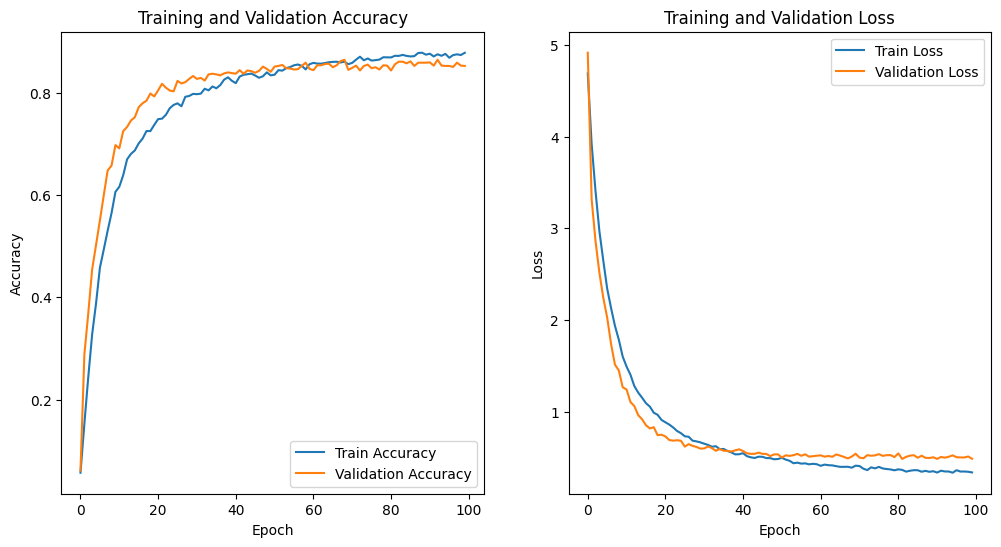

In [68]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc * 100:.2f}%")

# plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [69]:
# Get predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
test_accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 85.27%


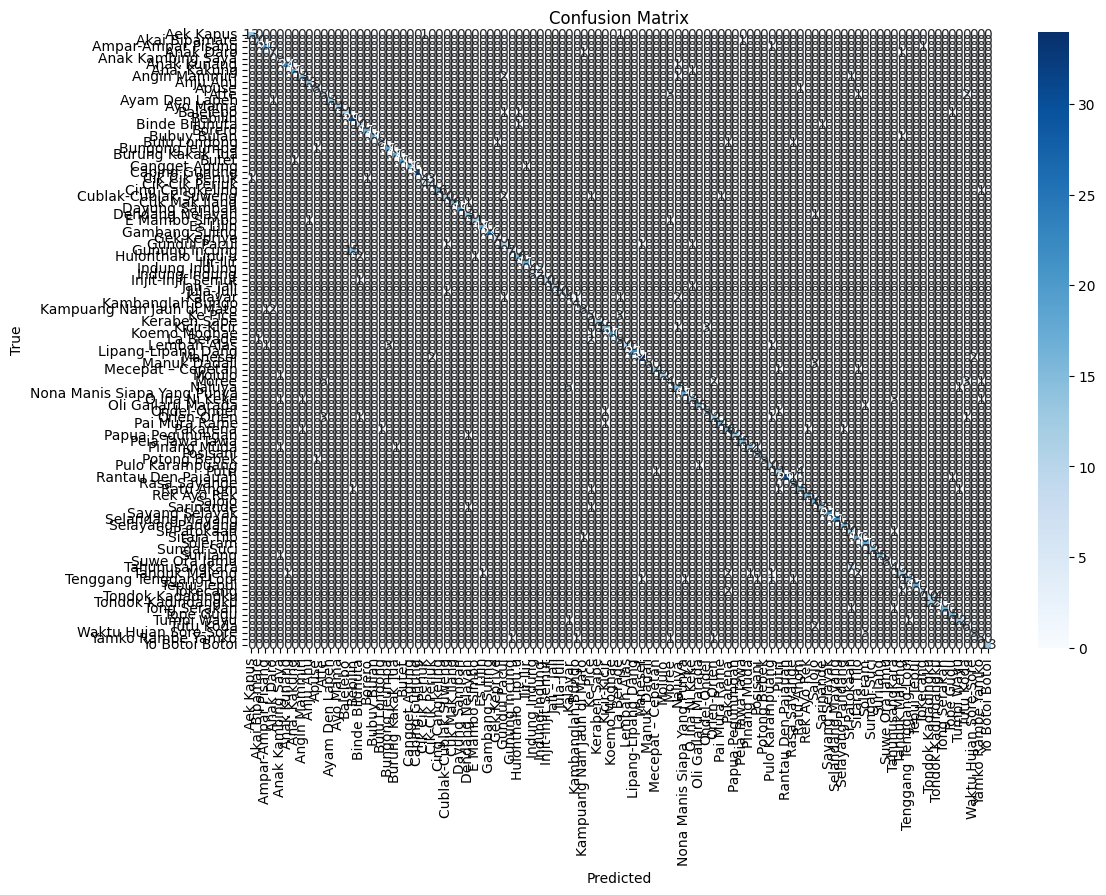

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [72]:
from pydub import AudioSegment
from io import BytesIO
import noisereduce as nr

def convert_to_wav(audio_path):
    audio = AudioSegment.from_file(audio_path)
    wav_io = BytesIO()
    audio.export(wav_io, format="wav")
    wav_io.seek(0)
    return wav_io

# predict
def predict_song_genre(model, file_path):
    # Extract features
    wav = convert_to_wav(file_path)
    features = mfcc_features(wav)
    
    if features is not None:
        # Make prediction
        pred_features = features.reshape(1, -1)
        pred = model.predict(pred_features)
        pred_class = np.argmax(pred)
        
        # Get the predicted class label
        predicted_label = label_encoder.classes_[pred_class]
        
        # Get the predicted class probability
        pred_prob = pred[0][pred_class]
        
        return pred_class, pred_prob, predicted_label
    else:
        return None


/home/reiaslite/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
# Test the prediction function
file_path = 'datasets/test'

for file in os.listdir(file_path):
    if file.endswith('.wav'):
        pred_class, pred_prob, pred_label = predict_song_genre(model, f"{file_path}/{file}")
        print(f"Predicted Genre: {pred_label} with probability: {pred_prob:.2f}")


# pred_class, pred_prob, pred_label = predict_song_genre(model, file_path)
# print(f"Predicted Genre: {pred_label} with probability: {pred_prob:.2f}")


ERROR:root:Error encountered during augmentation: pitch_shift() takes 1 positional argument but 3 were given


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


ERROR:root:Error encountered during augmentation: pitch_shift() takes 1 positional argument but 3 were given


Predicted Genre: Ampar-Ampar Pisang with probability: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Genre: Borero with probability: 0.70


ERROR:root:Error encountered during augmentation: pitch_shift() takes 1 positional argument but 3 were given


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Genre: Cuk Mak Ilang with probability: 0.32


In [18]:
import tensorflowjs as tfjs

# save model
# tf.keras.models.save_model(model, 'model/my_model.h5')
model.save('model.keras')

# load model
# saved_model = tf.keras.models.load_model('best_model.keras')

# # Save the model in TensorFlow.js format
# tfjs.converters.save_keras_model(saved_model, 'model/tfjs_model')

In [35]:
# load model
model = tf.keras.models.load_model('best_model.keras')